In [1]:
%pylab inline
from joblib import Parallel, delayed
import pandas
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from itertools import combinations

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pandas.read_csv("CND-features_processed.csv")

### Evaluate the Random Forest classifier by stratified cross validation:

In [3]:
def F1score(dataframe, features, CND, CV, ENSEMBLE):
    dataframe = dataframe[["Id"]+features+["CND"]]
    X = dataframe.values[:, 1:-1].astype(float)
    y = dataframe.values[:,   -1]
    indxGROUP = where(y == CND)[0]
    indxOTHER = where(y != CND)[0]
    y[indxGROUP] = 1
    y[indxOTHER] = 0
    y = y.astype(int)
    model = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample", max_depth=3)
    cv = RepeatedStratifiedKFold(n_splits=CV, n_repeats=ENSEMBLE)
    SCORE_TEST = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        SCORE_TEST.append(f1_score(y_test, model.predict(X_test)))
    return mean(SCORE_TEST)

### Assign scores to feature combinations in different CND scenarios:
1. Calculate F1 scores for feature singlets, order them
2. Calculate F1 scores for feature dublets created from the first 15 feature singlets
3. Calculate F1 scores for feature triplets created from the first 15 feature singlets

Save results in the folder "$\textit{wrapping}$"

In [4]:
def Scores4Group(dataframe, CND, dimension, NJOBS=-1):
    dfg = dataframe[["Id"]+list(loadtxt("filter/"+CND+".txt", dtype="str"))+["CND"]]
    if (dimension > 1):
        # do combination only on first 15 features due to computational complexity ...
        oneDimData = loadtxt("wrapping/1D/"+CND+".txt", dtype="str")
        dfg = dfg[["Id"]+list(oneDimData[argsort(oneDimData[:, 1].astype(float))[::-1]][:15, 0])+["CND"]]
    cols = list(dfg.columns[1:-1])
    # parallelize over columns:
    Score = Parallel(n_jobs=NJOBS)(
        delayed(F1score)(dfg, list(features), CND, 5, 3)
        for features in combinations(cols, dimension)
    )
    curve = array(Score)
    figure(figsize=(16, 4))
    bar(arange(len(curve)), curve[argsort(curve)[::-1]])
    title("CND = "+CND)
    ylabel("F1 score")
    grid()
    if (dimension == 1):
        xticks(arange(len(curve)), array(dfg.columns[1:-1])[argsort(curve)[::-1]], rotation = 30, ha="right");
    savetxt("wrapping/"+str(dimension)+"D/"+CND+".txt", 
            concatenate([array(list(combinations(dfg.columns[1:-1], dimension))), 
                         curve.reshape(-1, 1)], axis=1), fmt="%s")

### Results for feature singlets:

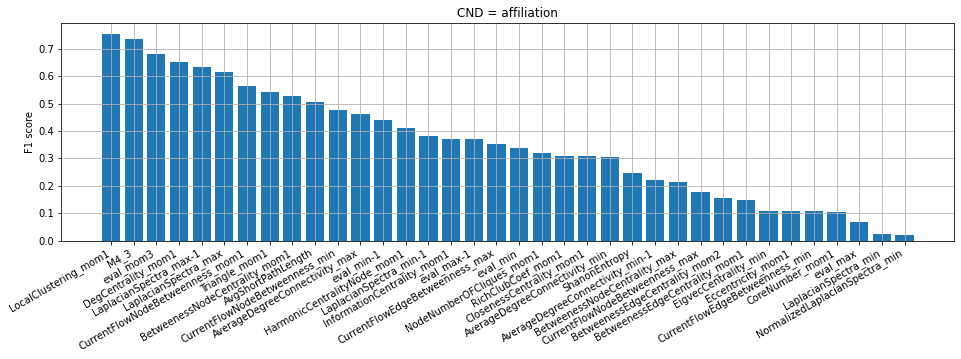

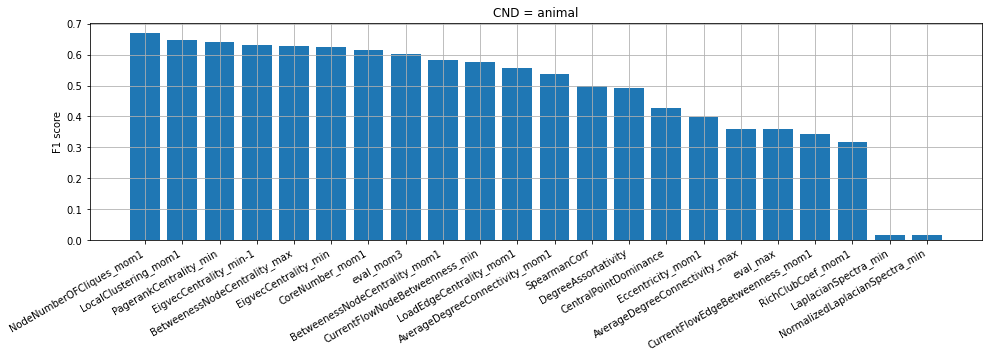

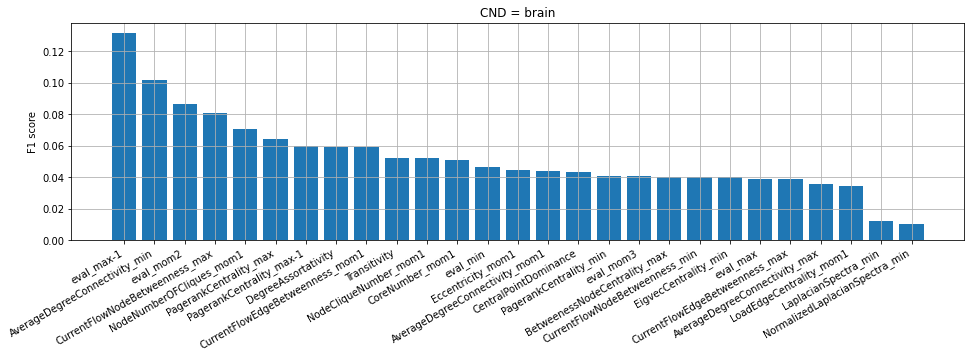

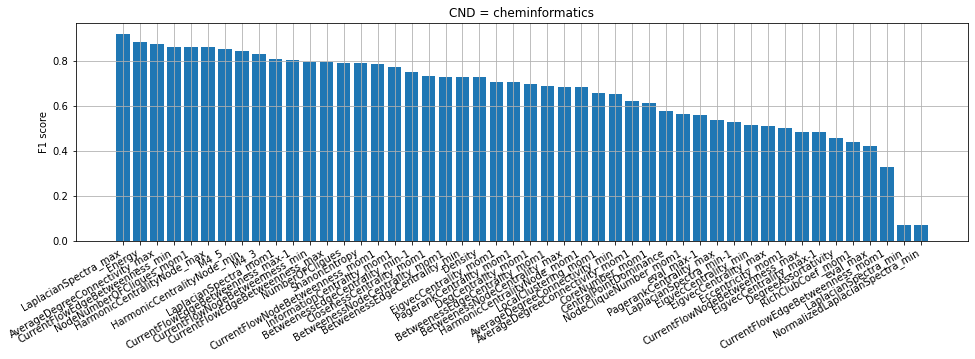

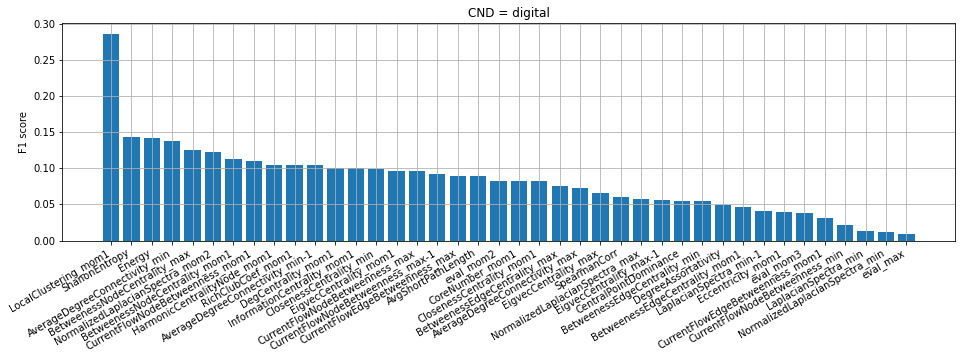

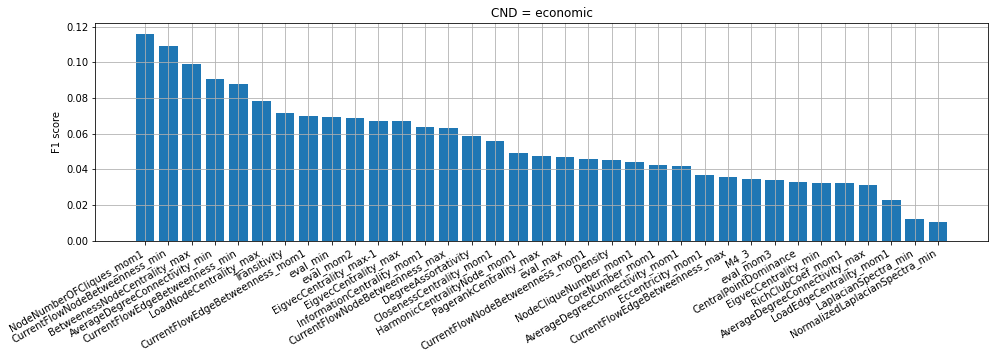

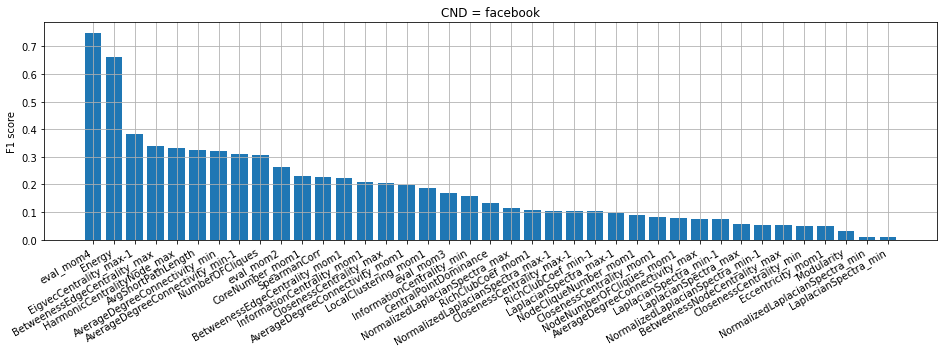

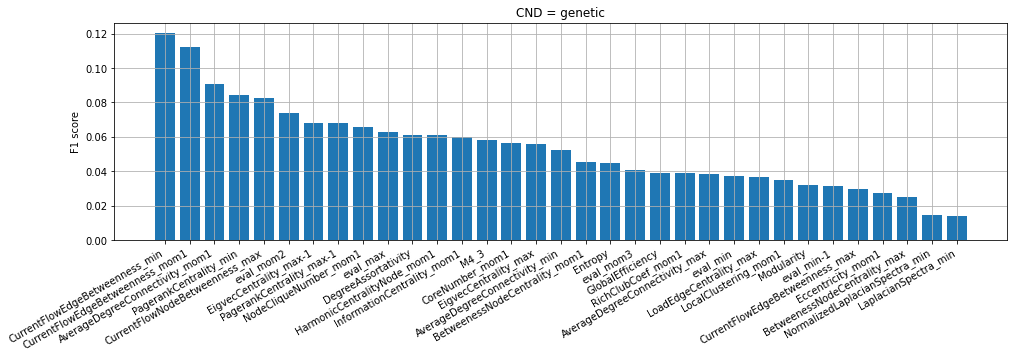

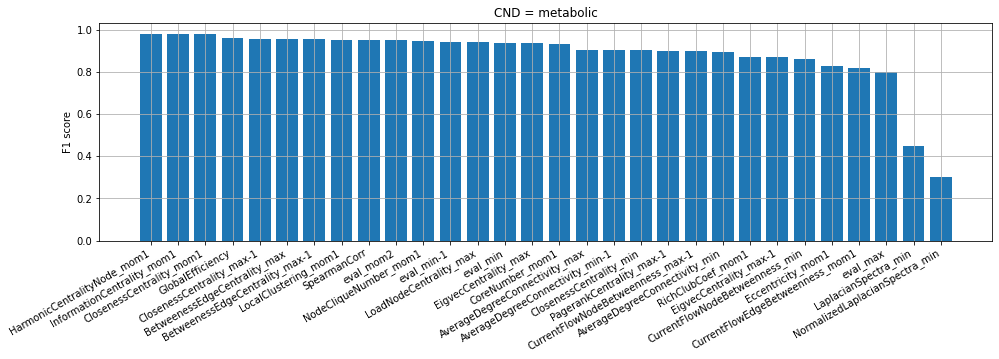

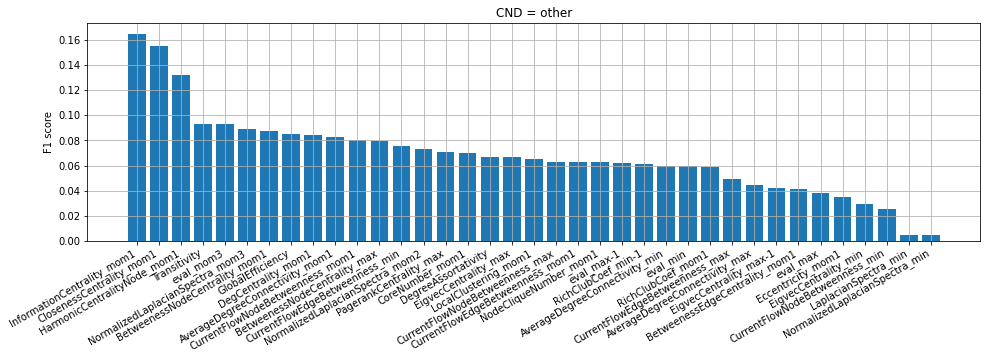

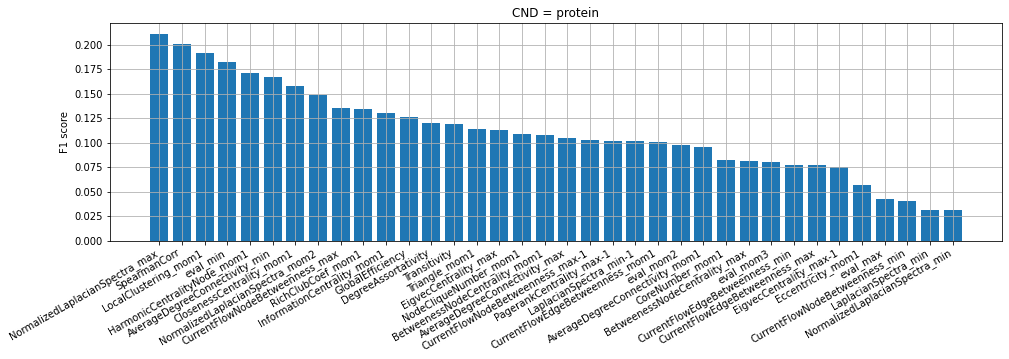

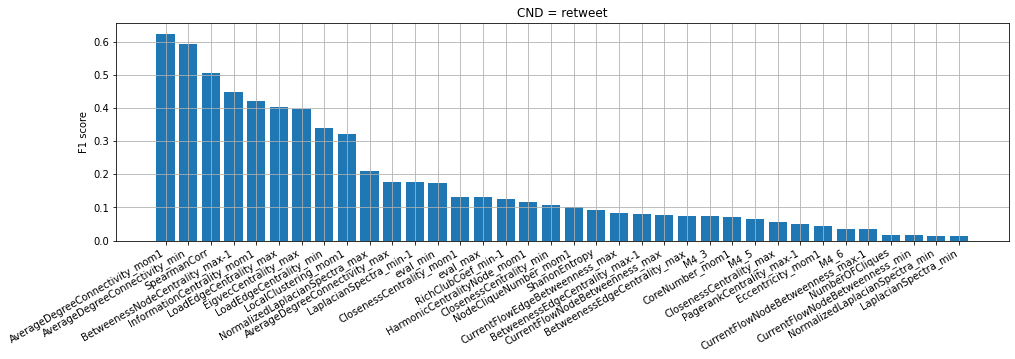

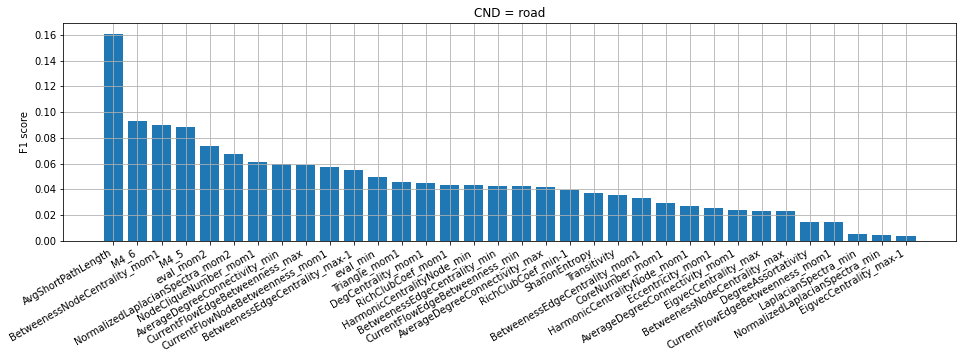

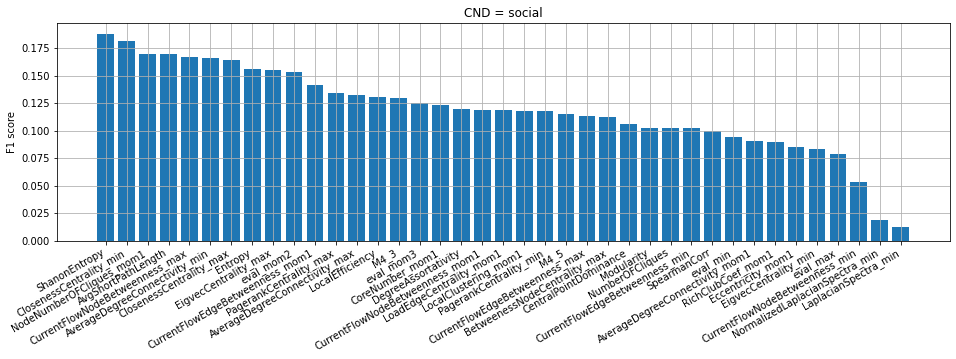

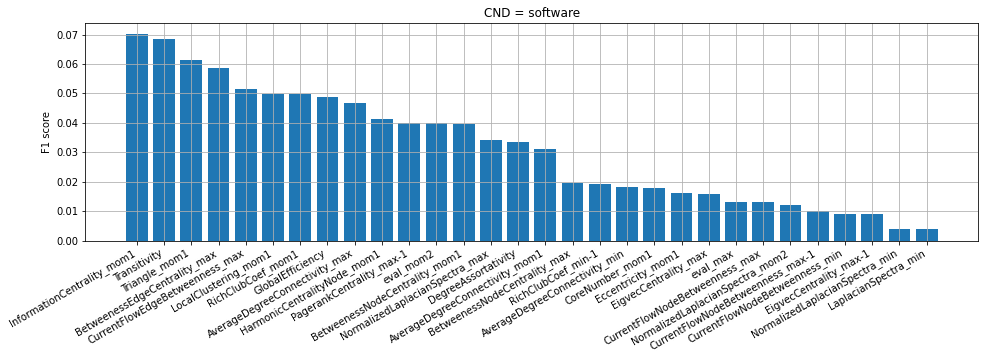

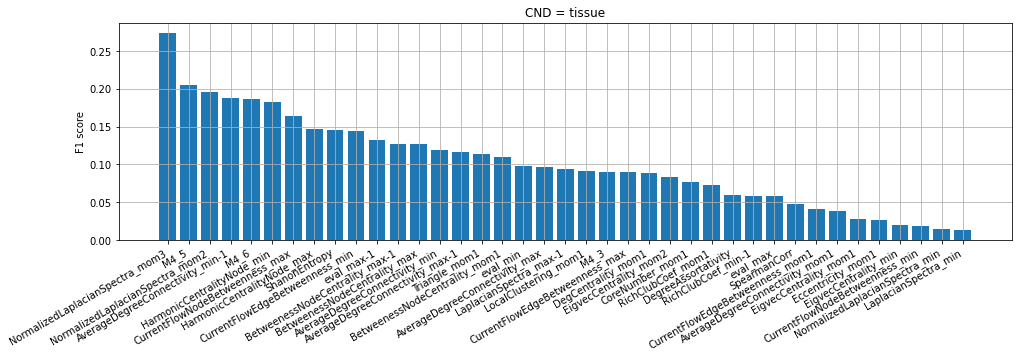

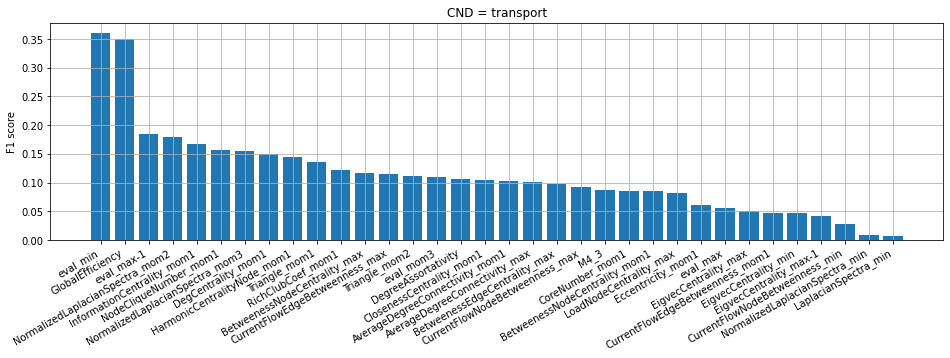

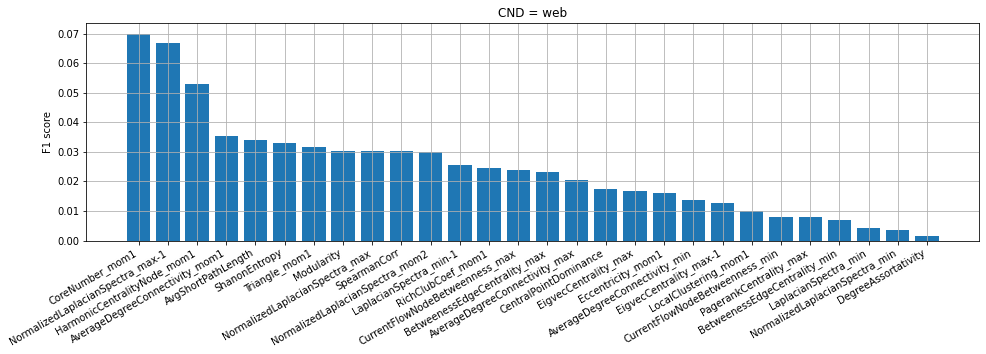

In [5]:
for CND in unique(df.CND):
    Scores4Group(df, CND, 1)

### Results for feature doublets:

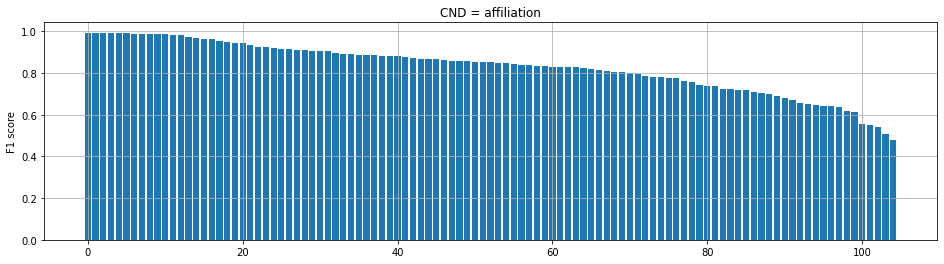

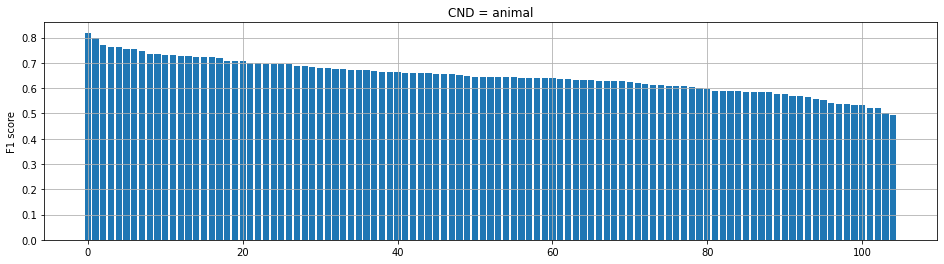

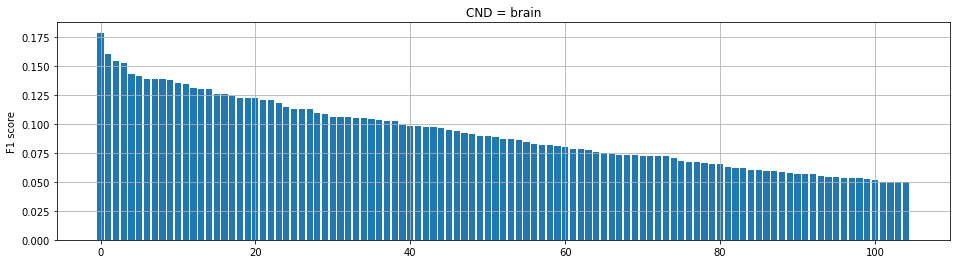

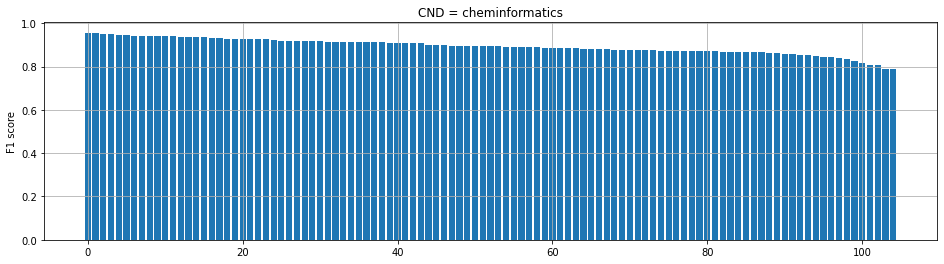

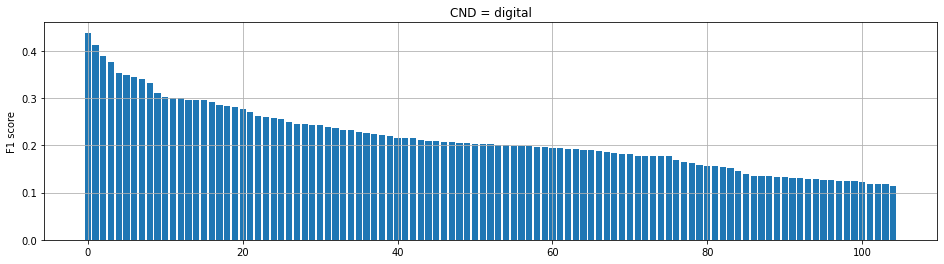

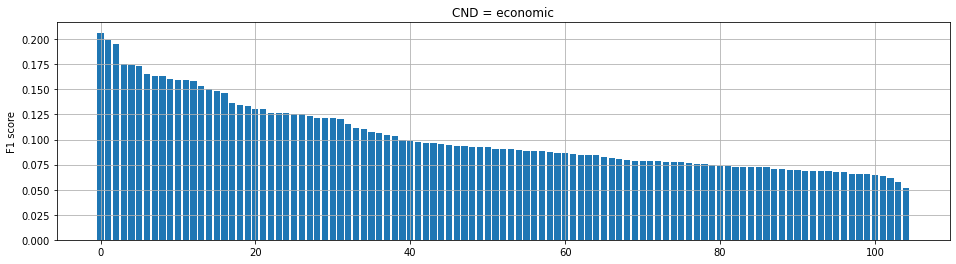

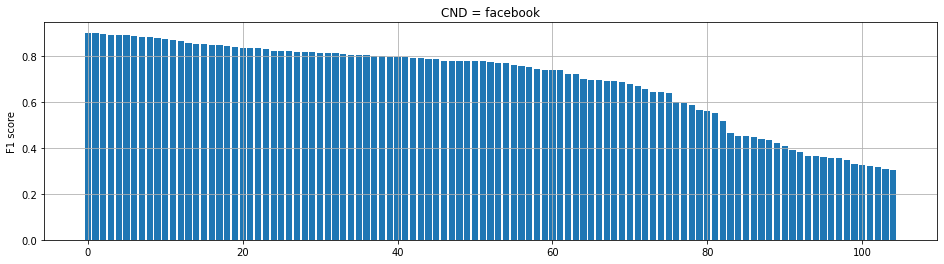

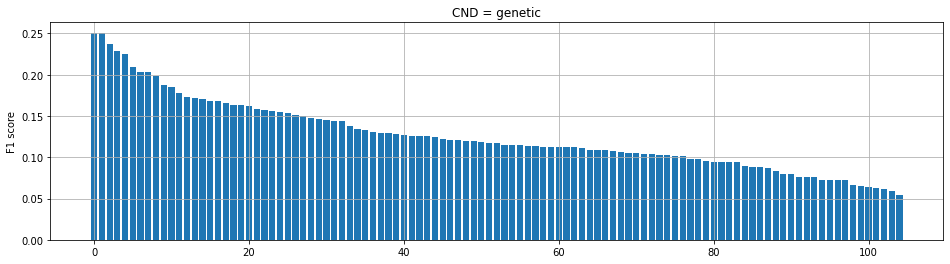

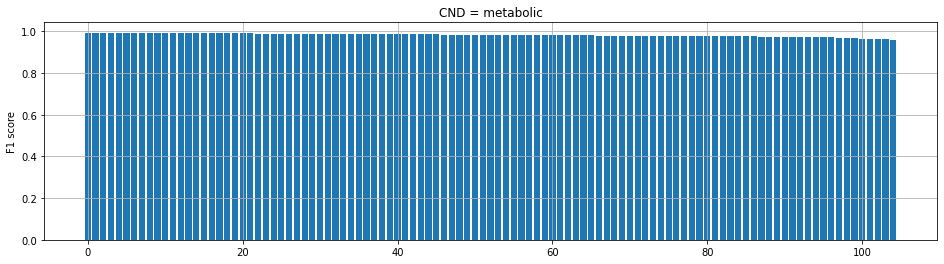

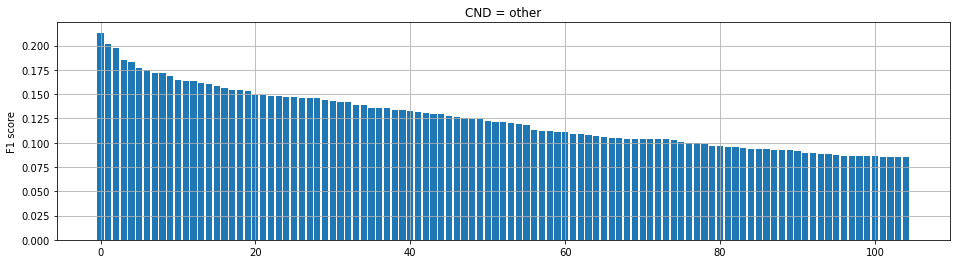

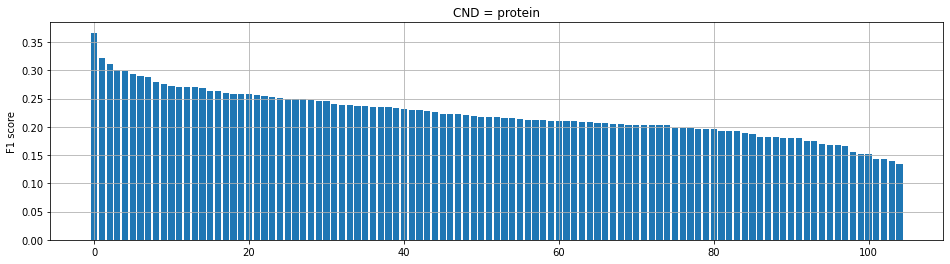

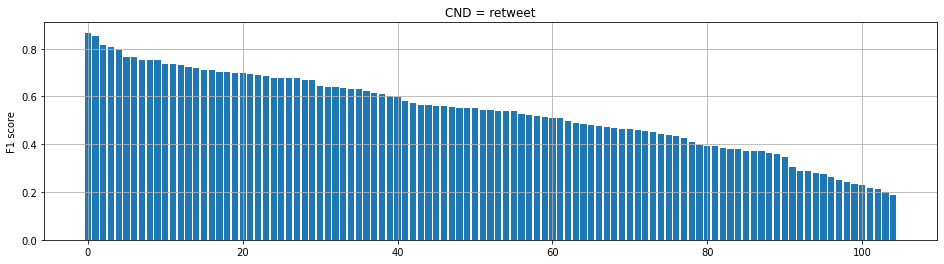

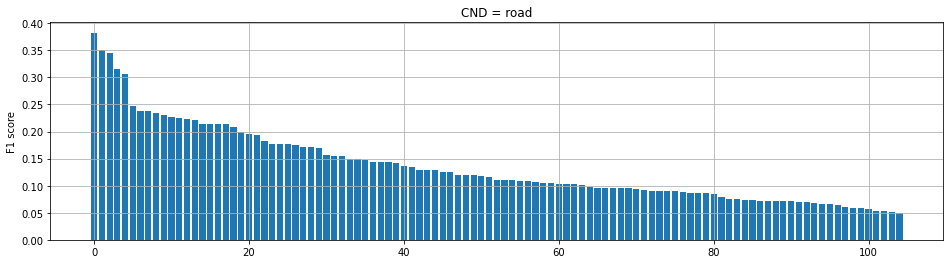

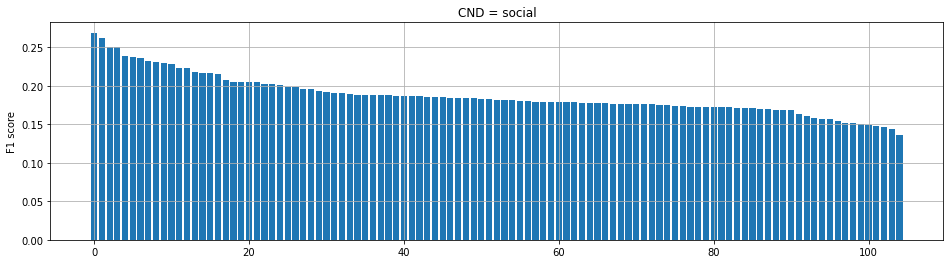

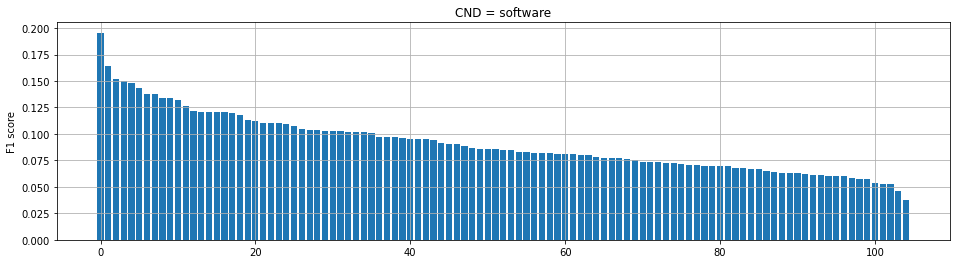

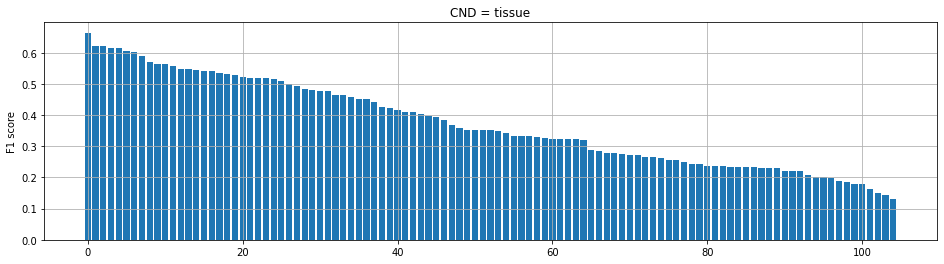

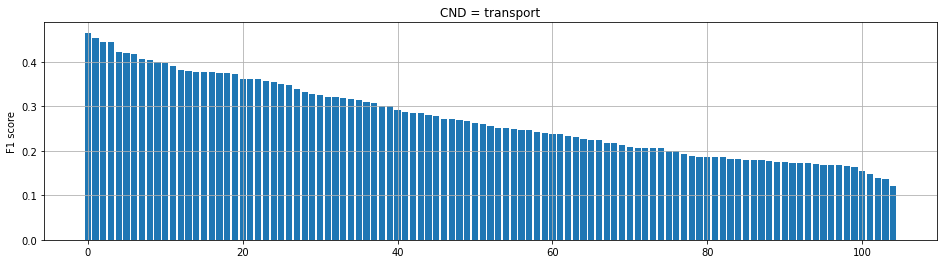

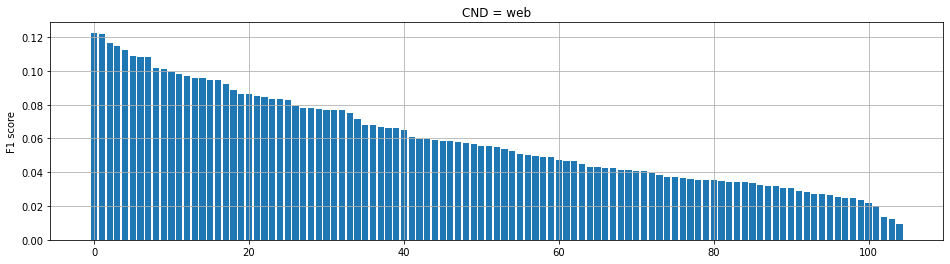

In [6]:
for CND in unique(df.CND):
    Scores4Group(df, CND, 2)

### Results for feature triplets:

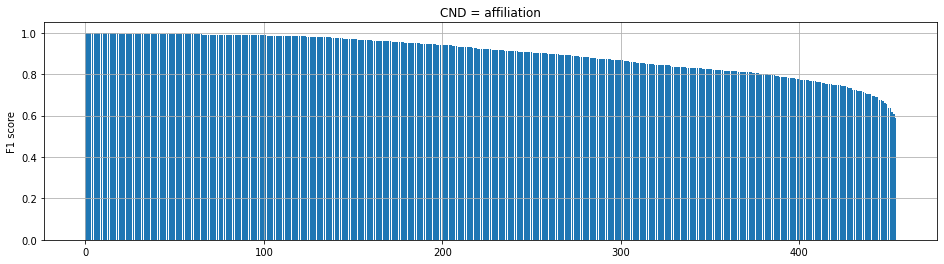

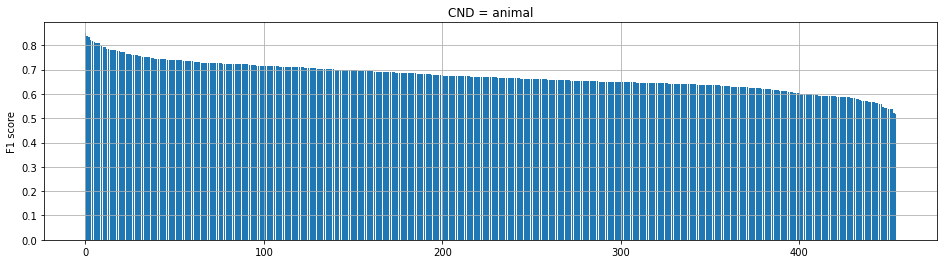

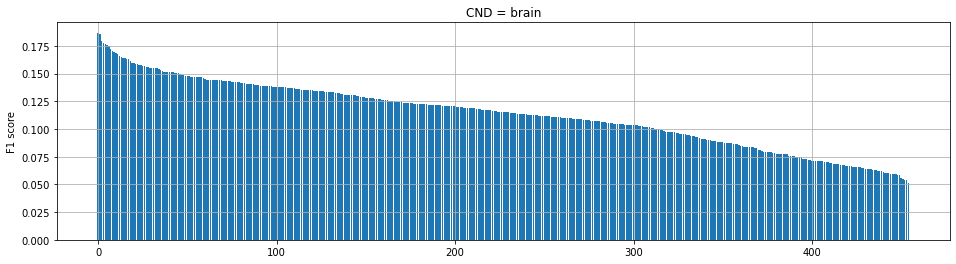

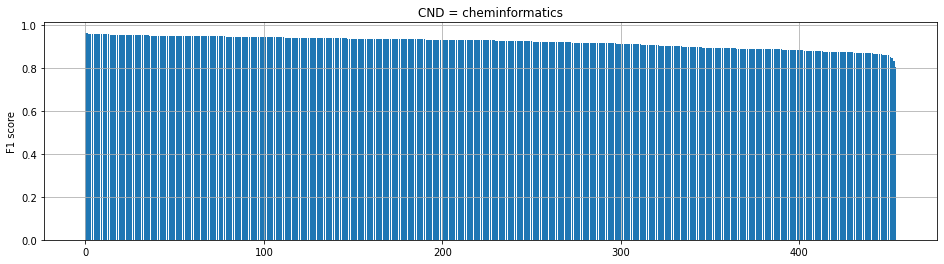

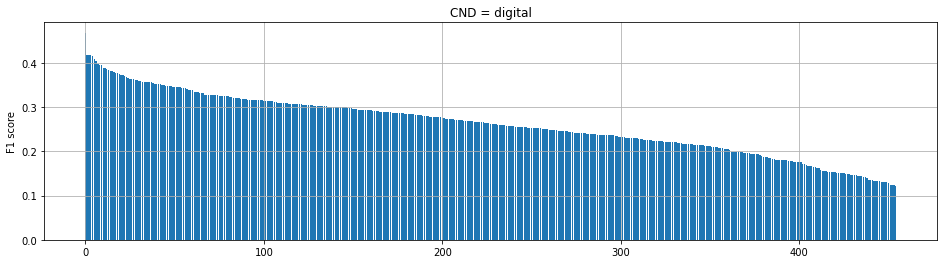

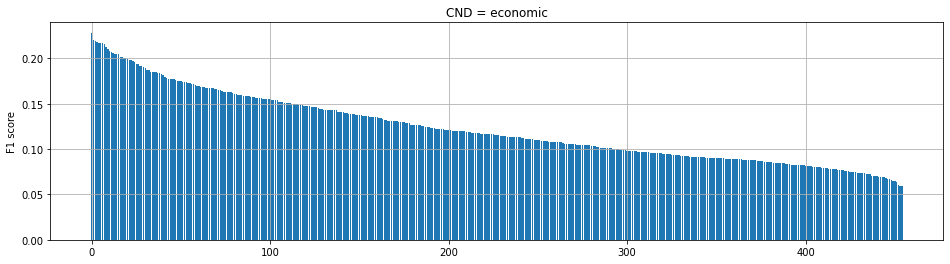

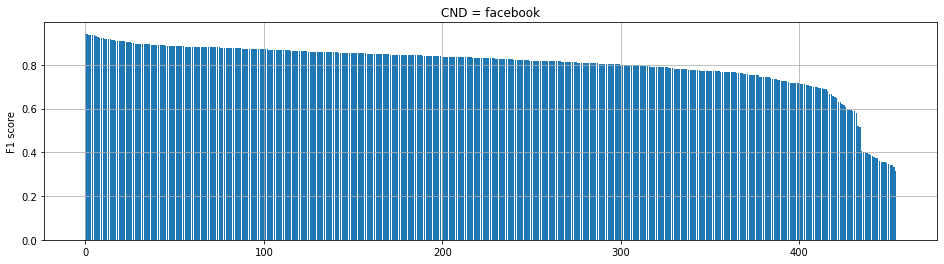

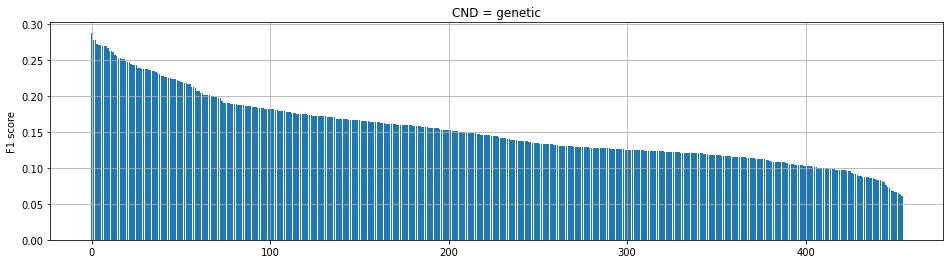

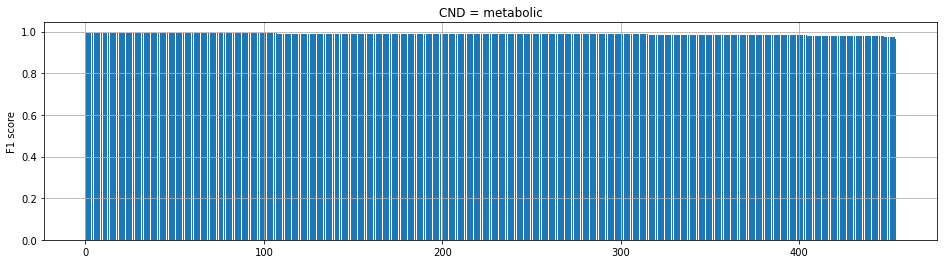

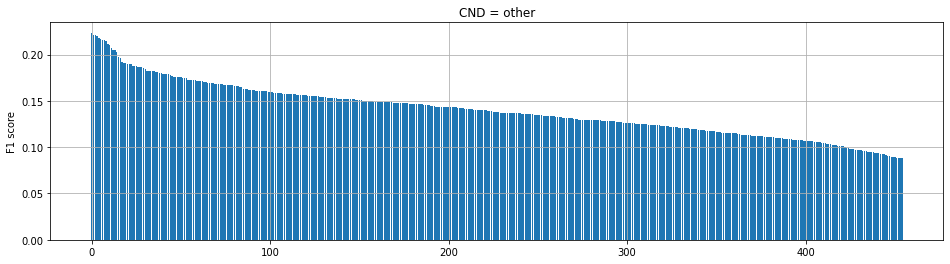

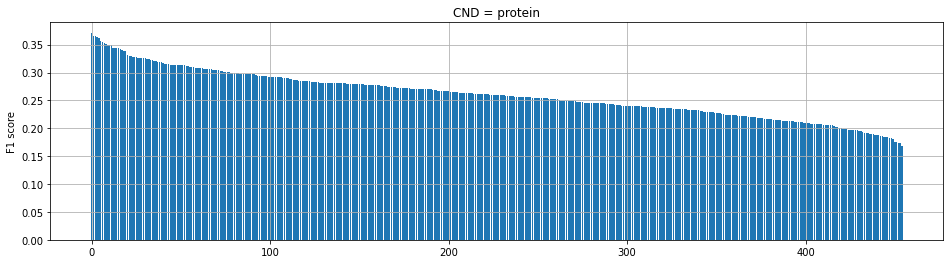

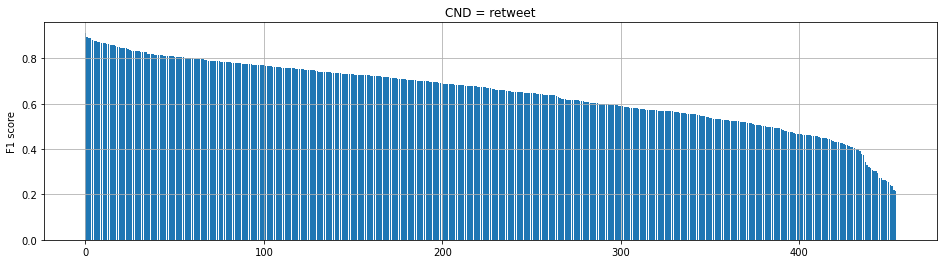

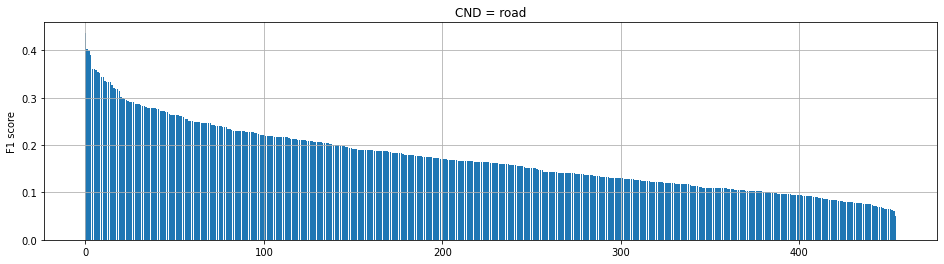

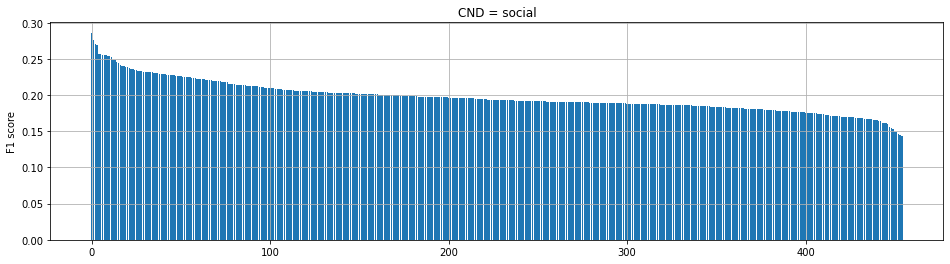

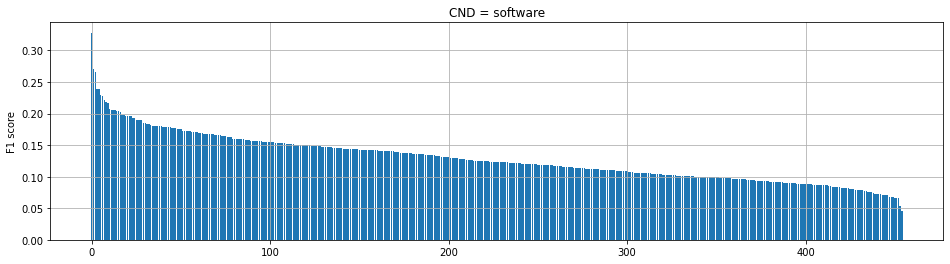

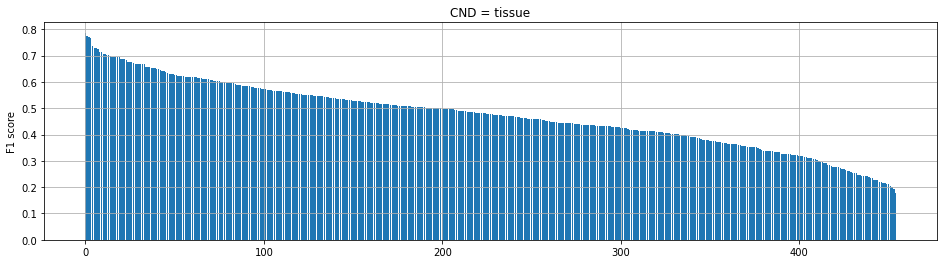

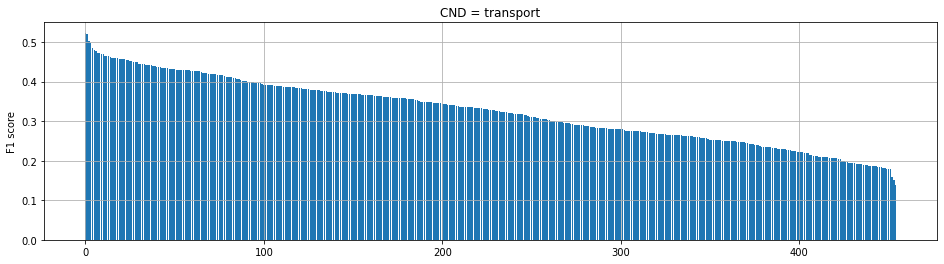

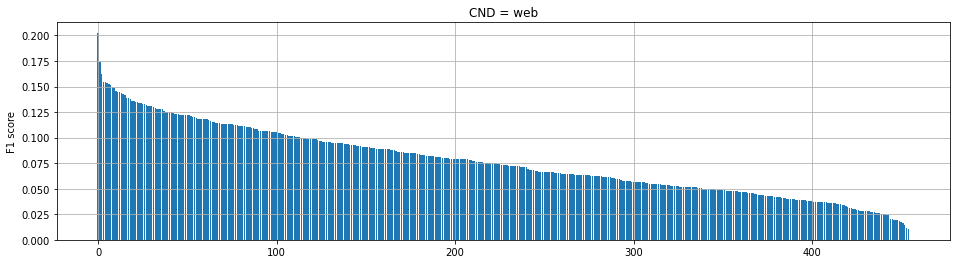

In [7]:
for CND in unique(df.CND):
    Scores4Group(df, CND, 3)